# Example 001: Analytical Resonator fitting

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import iddefix

### Modelling a three resonator impedance spectrum by three arbitrary resonators

Any arbitrary number of resonators can be initialized. This is example will demonstrate the creation of three resonators with the resonatorFormulas functions and later fitting.

Three random resonators ($R_s$, Q, $f_r$):

1. 400 $\Omega$, 30, 0.2 GHz
2. 1000 $\Omega$, 10, 1 GHz
3. 500 $\Omega$, 20, 1.75 GHz

In [2]:
# Assigning the resonator parameters

parameters ={   '1': [400, 30, 0.2e9],
                '2': [1000, 10, 1e9],
                '3': [500, 20, 1.75e9],}

# Computing the impedance spectrum for the resonators

frequency = np.linspace(0, 2e9, 1000)

impedance = iddefix.Impedances.n_Resonator_longitudinal_imp(frequency, parameters)

#### Plotting the impedance spectrum

Plots of both the real- and imaginary part of the impedance, as well as the absolute of the complex impedance 

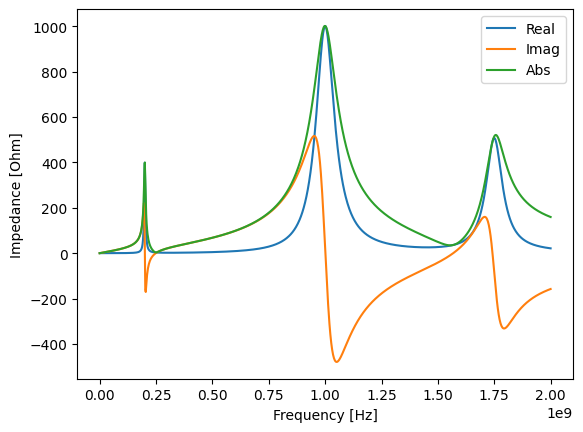

In [3]:
plt.plot(frequency, impedance.real, label='Real')
plt.plot(frequency, impedance.imag, label='Imag')
plt.plot(frequency, np.abs(impedance), label='Abs')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Impedance [Ohm]')
plt.legend()

### Fitting resonators with IDDEFIX on the absolute magnitude of the 3 resonator impdance spectrum

In [4]:
# Setting amount of resonators to fit

Nres = 3

# Bounds on resonators parameters
""" Bounds have this format [(Rs_min, Rs_max), (Q_min, Q_max), (fres_min, fres_max)].
ParameterBounds allows us to manually add a resonator with desired parameters """

parameterBounds = [(0, 2000), (1, 1e3), (0.1e9, 2e9),
                   (0, 2000), (1, 1e3), (0.1e9, 2e9),
                   (0, 2000), (1, 1e3), (0.1e9, 2e9)]

#### Running IDDEFIX DE
Running the DE algorithm with IDDEFIX and chosen parameters. A good rule-of-thumb is to have the population set at N = 5 * Nres. Mutation parameters and crossover_rate can be changed to adjust level of exploration/exploitation.

In [15]:
%%time
DE_model = iddefix.EvolutionaryAlgorithm(frequency, 
                                         impedance,
                                         N_resonators=Nres, 
                                         parameterBounds=parameterBounds,
                                         plane="longitudinal", 
                                         objectiveFunction=iddefix.ObjectiveFunctions.sumOfSquaredError)

DE_model.run_differential_evolution(maxiter=400,
                                    popsize=45,
                                    tol=0.01,
                                    mutation=(0.4, 1.0),
                                    crossover_rate=0.7)
print(DE_model.warning)

Optimization Progress: 100%|██████████| 375/375 [00:05<00:00, 65.19it/s]



----------------------------------------------------------------------
Resonator |   Rs [Ohm/m or Ohm]    |        Q         |    fres [Hz]     
----------------------------------------------------------------------
    1     |        5.05e+02        |      20.31       |    1.750e+09     
    2     |        1.00e+03        |       9.97       |    1.000e+09     
    3     |        4.06e+02        |      27.94       |    1.999e+08     
----------------------------------------------------------------------
Maximum number of iterations has been exceeded.
CPU times: user 4.66 s, sys: 422 ms, total: 5.08 s
Wall time: 5.75 s


The found resonator parameters are close to being exactly correct. We can fit better by running for more generations or by doing the mimimization step:

#### Minimization step
To further refine the solution obtained by the DE algorithm, a second optimization step is applied using the Nelder-Mead minimization algorithm. This additional step starts with the results from the DE algorithm as the initial guess and iteratively adjusts the parameters
within a predefined range of 10% above or below their original values. By doing so, the
Nelder-Mead algorithm fine-tunes the solution to reduce the error further, leveraging its
capability to explore the local parameter space efficiently. This two-step optimization ap-
proach ensures a more precise fit by combining the global search power of DE with the local
refinement capabilities of Nelder-Mead.

In [16]:
DE_model.run_minimization_algorithm()

Method for minimization : Nelder-Mead


----------------------------------------------------------------------
Resonator |   Rs [Ohm/m or Ohm]    |        Q         |    fres [Hz]     
----------------------------------------------------------------------
    1     |        5.00e+02        |      20.00       |    1.750e+09     
    2     |        1.00e+03        |      10.00       |    1.000e+09     
    3     |        4.00e+02        |      30.00       |    2.000e+08     
----------------------------------------------------------------------


### Assesing the fitting visually

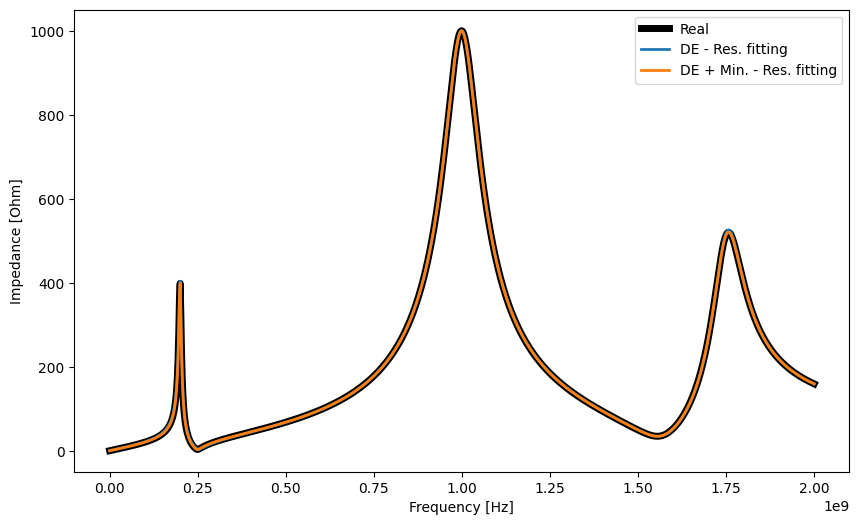

In [17]:
plt.figure(figsize=(10, 6))
result_DE = np.abs(iddefix.Impedances.n_Resonator_longitudinal_imp(frequency, DE_model.evolutionParameters))
result_DE_MIN = np.abs(iddefix.Impedances.n_Resonator_longitudinal_imp(frequency, DE_model.minimizationParameters))

plt.plot(frequency, np.abs(impedance), lw=5, label='Real', color='black')
plt.plot(frequency, result_DE,  lw=2, label='DE - Res. fitting')
plt.plot(frequency, result_DE_MIN,  lw=2, label='DE + Min. - Res. fitting')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Impedance [Ohm]')
plt.legend()